### Introduction

This notebook takes the manifest and uses it to embed all image captions available avaible in a FAISS vector databse with langchain and granite-embedding:30m

```
ollama pull nomic-embed-text:v1.5
``` 

### Importing and Paths

Change the ROOT  paths as needed. It should point to to the main knowledge pack dir.

In [6]:
# --- A. Imports & config ---
from pathlib import Path
import json, hashlib, uuid, yaml
from typing import List, Dict
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

# Paths (adapt for your pack root)
ROOT = Path("/Users/ktejwani/Personal CS Projects/Summer 2025/Offline AI Kiosk/Offline-AI-Kiosk/first_aid_knowledge_pack_v3")
MANIFEST = ROOT / "manifest.yaml"
print(ROOT)
print(MANIFEST)

/Users/ktejwani/Personal CS Projects/Summer 2025/Offline AI Kiosk/Offline-AI-Kiosk/first_aid_knowledge_pack_v3
/Users/ktejwani/Personal CS Projects/Summer 2025/Offline AI Kiosk/Offline-AI-Kiosk/first_aid_knowledge_pack_v3/manifest.yaml


### Parsing YAML, Embedding Documents, and Creating Vector Store

NOTES: 
1. Below cell will create a new directory inisde the knolwedge pack:
- Example: first_aid_pack_demo_v2/vector_db/text/faiss_index <br>
This directory will have the actual .faiss store and index pickle file

2. embeddings.jsonl, index.bin, and meta.json under first_aid_pack_demo_v2/vector_db/text/faiss_index will be overwritten.

In [7]:
with open(MANIFEST, "r", encoding="utf-8") as f:
    manifest = yaml.safe_load(f)

# Pull embedding config from manifest
embed_model_name = manifest["embedding_config"]["images"]["model"]     # e.g., "granite-embedding:278m"
normalize = bool(manifest["embedding_config"]["images"].get("normalize", True))

# Resolve precomputed index paths from manifest
images_idx_cfg   = manifest["precomputed_indices"]["images"]
embeddings_path = ROOT / images_idx_cfg["embeddings"]                  # "vector_db/images/embeddings.jsonl"
meta_path       = ROOT / images_idx_cfg["meta"]                        # "vector_db/images/meta.json"
faiss_dir       = ROOT / images_idx_cfg["faiss"]["dir"]                # "vector_db/images/faiss_index"
faiss_index_path    = ROOT / images_idx_cfg["faiss"]["index"]          # ".../index.faiss"
faiss_docstore_path = ROOT / images_idx_cfg["faiss"]["docstore"]       # ".../index.pkl"
captions_path = ROOT / images_idx_cfg["captions"]


faiss_dir.mkdir(parents=True, exist_ok=True)
embeddings_path.parent.mkdir(parents=True, exist_ok=True)
meta_path.parent.mkdir(parents=True, exist_ok=True)
captions_path.parent.mkdir(parents=True, exist_ok=True)

print("Using FAISS dir:", faiss_dir)
print("Embeddings JSONL:", embeddings_path)
print("Meta JSON:", meta_path)

# ---------- 1) Embeddings ----------
from langchain_ollama import OllamaEmbeddings

# Local Ollama embeddings (granite)
emb = OllamaEmbeddings(model=embed_model_name)


# ---------- 2) Build LangChain Documents with rich metadata ----------
docs: List[Document] = []
pack_name    = manifest["name"]
pack_ver     = manifest["version"]
pack_locales = manifest["locales"]

# citation id -> full object (already built)
citations = {c["id"]: c for c in manifest.get("citations", [])}

assets = manifest.get("assets", [])
for a in assets:
    caption = (a.get("image_description") or a.get("alt_text") or "").strip()
    tags    = " ".join(a.get("tags", [])).strip()
    text    = " | ".join(t for t in [caption, tags] if t)

    # --- expand image citation IDs to full objects (like text pipeline) ---
    c_ids  = a.get("citations", []) or []
    c_full = [citations[cid] for cid in c_ids if cid in citations]


    docs.append(Document(
        page_content=text,
        metadata={
            "pack_name": pack_name,
            "pack_version": pack_ver,
            "id": a["id"],
            "path": a["path"],
            "media_type": a.get("media_type", "image/png"),
            "locale": a.get("locale", "hi_en"),
            # Keep BOTH for convenience:
            "citation_ids": c_ids,   # raw IDs as in manifest
            "citations": c_full,     # expanded objects (title/url/license)
        }
    ))


print(f"Prepared {len(docs)} image-caption docs")


# ---------- 3) Create FAISS & persist (no extra copies) ----------
from langchain_community.vectorstores import FAISS

vs = FAISS.from_documents(docs, emb)
vs.save_local(str(faiss_dir))  # writes index.faiss + index.pkl (overwrites if they exist)

# sanity check
assert faiss_index_path.exists(), f"Missing {faiss_index_path}"
assert faiss_docstore_path.exists(), f"Missing {faiss_docstore_path}"
print("FAISS artifacts saved ✅", faiss_index_path.name, "&", faiss_docstore_path.name)

# ---------- 4) Export JSONL embeddings + meta (portable) ----------
# Note: this re-embeds each chunk for JSONL output. For big corpora, cache vectors during creation.
records = []
# Access the docstore that FAISS is holding (doc_id -> Document)
doc_items = getattr(vs.docstore, "_dict", {})  # internal but commonly used

for doc_id, doc in doc_items.items():
    vec = emb.embed_query(doc.page_content)  
    rec = {
        "id": doc_id,
        "embedding": vec,
        "metadata": doc.metadata,
        "text": doc.page_content
    }
    records.append(rec)

with open(embeddings_path, "w", encoding="utf-8") as f:
    for r in records:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

with open(meta_path, "w", encoding="utf-8") as f:
    json.dump({
        "model": embed_model_name,
        "dim": manifest["embedding_config"]["images"]["dim"],
        "normalize": normalize,
        "count": len(records),
        "pack": {"name": pack_name, "version": pack_ver, "locales": pack_locales}
    }, f, ensure_ascii=False, indent=2)

n = 0
with open(captions_path, "w", encoding="utf-8") as f:
    for doc_id, doc in doc_items.items():
        md = doc.metadata or {}
        # Build a compact record with helpful fields
        rec = {
            "pack_name": pack_name,
            "pack_version": pack_ver,
            "id": doc_id,                               
            "asset_id": md.get("id"),                  
            "path": md.get("path"),
            "locale": md.get("locale", "hi_en"),
            "media_type": md.get("media_type", "image/png"),
            "citation_ids": md.get("citation_ids", []),
            "citation_titles": [c.get("title", "") for c in md.get("citations", [])],
            "text": doc.page_content                    # caption 
        }
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")
        n += 1

print(f"Captions JSONL saved ✅ {captions_path} ({n} rows)")

print("JSONL/meta saved ✅")


Using FAISS dir: /Users/ktejwani/Personal CS Projects/Summer 2025/Offline AI Kiosk/Offline-AI-Kiosk/first_aid_knowledge_pack_v3/vector_db/images/faiss_index
Embeddings JSONL: /Users/ktejwani/Personal CS Projects/Summer 2025/Offline AI Kiosk/Offline-AI-Kiosk/first_aid_knowledge_pack_v3/vector_db/images/embeddings.jsonl
Meta JSON: /Users/ktejwani/Personal CS Projects/Summer 2025/Offline AI Kiosk/Offline-AI-Kiosk/first_aid_knowledge_pack_v3/vector_db/images/meta.json
Prepared 25 image-caption docs
FAISS artifacts saved ✅ index.faiss & index.pkl
Captions JSONL saved ✅ /Users/ktejwani/Personal CS Projects/Summer 2025/Offline AI Kiosk/Offline-AI-Kiosk/first_aid_knowledge_pack_v3/vector_db/images/captions.jsonl (25 rows)
JSONL/meta saved ✅


### Testing it out

In [8]:
# Direct FAISS similarity search with scores
query = "How to put on tourniquet?"
results = vs.similarity_search_with_score(query, k=4)

for i, (d, score) in enumerate(results, 1):
    print(f"\n[{i}] (score={score:.4f})")
    print("PATH:", d.metadata["path"])
    print("Asset id:", d.metadata["id"])
    print("Locale:", d.metadata["locale"])
    print("Citations:", [c["title"] for c in d.metadata.get("citations", [])])
    print("Chunk text:")
    print(d.page_content[:300], "..." if len(d.page_content) > 300 else "")

print('*' * 100)




[1] (score=0.5723)
PATH: assets/bleeding/tourniquet.png
Asset id: img-bleeding-tourniquet
Locale: hi_en
Citations: ['Basic Emergency Care — World Health Organization']
Chunk text:
Improvised tourniquet for bleeding control. 

[2] (score=1.0443)
PATH: assets/bleeding/pressure.png
Asset id: img-bleeding-pressure
Locale: hi_en
Citations: ['Basic Emergency Care — World Health Organization']
Chunk text:
Apply firm pressure with cloth to wound. 

[3] (score=1.0685)
PATH: assets/heat/shade.png
Asset id: img-heat-shade
Locale: hi_en
Citations: ['Basic Emergency Care — World Health Organization']
Chunk text:
Move patient to shade, loosen clothing. 

[4] (score=1.1057)
PATH: assets/choking-cpr/heimlich.png
Asset id: img-choking-heimlich
Locale: hi_en
Citations: ['Basic Emergency Care — World Health Organization']
Chunk text:
Heimlich maneuver for choking adult. 
****************************************************************************************************


### Showing and choosing only 1 image

IMAGE FOUND FOR fracture steps

[1] (score=0.6985)
PATH: assets/fracture/splint.png
Asset id: img-splint
Locale: hi_en
Citations: ['First Aid Splint 36 X 4.3']
Chunk text:
Immobilize fractures with splint. Arm and leg. Broken bone. 


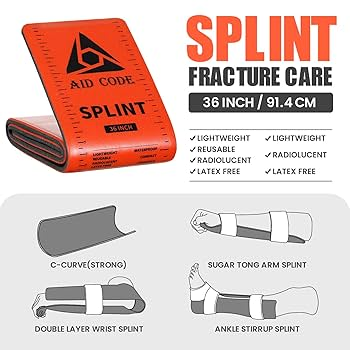

In [4]:
# Filter to only show one good enough image
query = "fracture steps"
foundImage = False
minScore = 0.32
finalDoc  = Document(page_content="")
results = vs.similarity_search_with_score(query, k=4)

from IPython.display import Image, display

for i, (d, score) in enumerate(results, 1):
    
    if score >= minScore:
        finalDoc = d
        foundImage = True
        break
if not foundImage:
    print("NO IMAGE FOUND FOR " + query)
else:
    print("IMAGE FOUND FOR " + query)
    print(f"\n[{i}] (score={score:.4f})")
    print("PATH:", finalDoc.metadata['path'])
    print("Asset id:", finalDoc.metadata["id"])
    print("Locale:", finalDoc.metadata["locale"])
    print("Citations:", [c["title"] for c in finalDoc.metadata.get("citations", [])])
    print("Chunk text:")
    print(finalDoc.page_content[:300], "..." if len(finalDoc.page_content) > 300 else "")
    img_path = ROOT / finalDoc.metadata['path']
    display(Image(filename=img_path))





# Display inline in Jupyter



IMAGE FOUND FOR QUERY:tourniquet on leg?

[1] (score=0.6207)
PATH: assets/bleeding/tourniquet.png
Asset id: img-tourniquet
Locale: hi_en
Citations: ['Journal of Trauma and Acute Care Surgery - DOI:10.1097/TA.0000000000000485']
Image caption:
Step-by-step improvised tourniquet using cloth and stick. Severe Bleeding. 


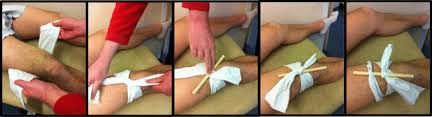

In [5]:
# Filter to only show one good enough image
query = "tourniquet on leg?"
foundImage = False
minScore = 0.32
finalDoc  = Document(page_content="")
results = vs.similarity_search_with_score(query, k=4)

from IPython.display import Image, display

for i, (d, score) in enumerate(results, 1):
    
    if score >= minScore:
        finalDoc = d
        foundImage = True
        break
if not foundImage:
    print("NO IMAGE FOUND FOR QUERY:" + query)
else:
    print("IMAGE FOUND FOR QUERY:" + query)
    print(f"\n[{i}] (score={score:.4f})")
    print("PATH:", finalDoc.metadata['path'])
    print("Asset id:", finalDoc.metadata["id"])
    print("Locale:", finalDoc.metadata["locale"])
    print("Citations:", [c["title"] for c in finalDoc.metadata.get("citations", [])])
    print("Image caption:")
    print(finalDoc.page_content[:300], "..." if len(finalDoc.page_content) > 300 else "")
    img_path = ROOT / finalDoc.metadata['path']
    display(Image(filename=img_path))

:)